# 2nd milestone

In [6]:
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Dense, Activation, BatchNormalization, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Flatten
import numpy as np
import scipy as sp
from skimage import color
import warnings
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [3]:
import pandas as pd
import urllib.request
import uuid
from PIL import Image
import requests
from io import BytesIO
import glob

# Own .py files
import data_collector
import image_loader
import nnetwork

#import image_loader
image_folder = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/samples/images/'
img_loader = image_loader.ImageLoader(image_folder)

# Separate_small_data(validation_rate, test_rate)
img_loader.separate_small_data(0.1,0.1)

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(99, 56, 56, 313)


In [4]:
model = nnetwork.create_vgg_model()
model.compile('adam', loss = 'categorical_crossentropy',
              metrics=['accuracy', keras.metrics.categorical_accuracy])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 512)         2048      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 56, 56, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 256)       1179904   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       590080    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 313)       80441     
Total params: 16,567,161
Trainable params: 8,930,873
Non-trainable params: 7,636,288
_________________________________________________________

In [7]:
patience=20
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

In [8]:
history = model.fit(x=img_loader.X_train,
                    y=img_loader.Y_train,
                    batch_size=32,
                    epochs=2,
                    validation_data=(img_loader.X_valid,img_loader.Y_valid),
                   callbacks=[checkpointer, early_stopping])

Train on 79 samples, validate on 10 samples
Epoch 1/2
79/79 [==============================] - 104s 1s/step - loss: 5.3130 - acc: 0.1917 - categorical_accuracy: 0.1917 - val_loss: 9.3937 - val_acc: 0.2498 - val_categorical_accuracy: 0.2498

Epoch 00001: val_loss improved from inf to 9.39369, saving model to weights.hdf5
Epoch 2/2
79/79 [==============================] - 99s 1s/step - loss: 3.5941 - acc: 0.2581 - categorical_accuracy: 0.2581 - val_loss: 8.6011 - val_acc: 0.1489 - val_categorical_accuracy: 0.1489

Epoch 00002: val_loss improved from 9.39369 to 8.60115, saving model to weights.hdf5


In [9]:
score = model.evaluate(img_loader.X_test, img_loader.Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10/10 [==============================] - 8s 777ms/step
Test loss: 7.951251029968262
Test accuracy: 0.09343112260103226


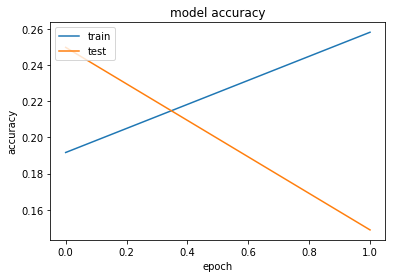

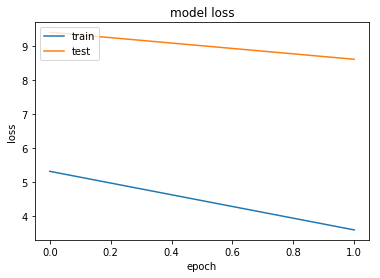

In [12]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

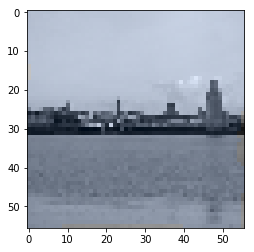

In [17]:
from matplotlib.pyplot import imshow
from skimage import color
import matplotlib.pyplot as plt
%matplotlib inline

idx = 10

y_real = model.predict(img_loader.X_train[idx].reshape((1,224,224,3)))
y_real = np.apply_along_axis(lambda x: img_loader.pts_in_hull[np.argmax(x)], axis=3, arr = y_real)
img_loader.pts_in_hull # létező színosztályok

lab_im = np.concatenate([img_loader.y_dataset[np.newaxis,idx,:,:,0, np.newaxis],y_real ], axis=3)
rgb_im = color.lab2rgb(lab_im[0])
plt.imshow(rgb_im)

In [ ]:
import cv2
import numpy as np

res = cv2.resize(img_loader.X_train[0], dsize=(56, 56), interpolation=cv2.INTER_CUBIC)
res = res.reshape((56,56,1))